# Preprocesamiento de datos

Para evitar tener que preprocesar los datos cada vez que abrimos el Google Colab vamos a realizar tanto particionado de los datos como su preprocesamiento en este notebook aparte.

## Cargar el dataset

Lo primero es cargar el dataset con Pandas y seleccionar la cantidad de filas que queremos usar:

In [1]:
import pandas as pd

df = pd.read_csv("dataset_definitivo.csv")
print(df['personality'].value_counts())

7     271107
3     227906
8     198143
4     183628
11    139942
12    128444
15     83261
5      65455
6      63511
2      58852
16     53388
1      46791
10     27698
9      19894
14     16627
13     14381
Name: personality, dtype: int64


## Filtrado de Stopwords, Tokenización y Stemming

El preprocesamiento de texto se realiza usando las stopwords y el tokenizer de la librería de lenguaje natural de Python. Primero definimos las stopwords, que serán las de la librería de Python y las personalidades Myers-Briggs para evitar introducir sesgos, como que, si se menciona una personalidad, que esta no se tenga en cuenta para decidir la del autor. Luego se usa el PorterStemmer para obtener la “raíz” de las palabras. Entonces el resultado es una nueva columna que contiene los posts preprocesados.

In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tqdm.contrib.concurrent import process_map
from tqdm import tqdm
from multiprocessing import cpu_count
import re

import nltk
nltk.download('punkt')
nltk.download('stopwords')

ps = PorterStemmer()


STOPS = set(stopwords.words("english"))
CUSTOM_STOPS = set(['istj', 'isfj', 'infj', 'intj',
                    'istp', 'isfp', 'infp', 'intp',
                    'estp', 'esfp', 'enfp', 'entp',
                    'estj', 'esfj', 'enfj', 'entj'])

def process_text(post):
    try:
        post = post.lower()
        post = re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',post) # filtrar links
        post = re.sub('[0-9]+',' ',post) # filtrar numeros
        post = re.sub('@[^\s]+',' ',post) # filtrar menciones de Twitter
        #post = re.sub('[^0-9a-z]',' ',post) # dejamos los carácteres especiales, pueden ser emojis con significado emocional
        post = re.sub('[a-z]{1,2,3}', ' ', post) # filtrar monogramas, bigramas y trigramas
        return " ".join(
            [ps.stem(w) for w in word_tokenize(post)
             if not w in STOPS and w not in CUSTOM_STOPS])
    except:
        print("problem with: ", post)


num_processes = cpu_count()

df['processed_text'] = process_map(
                    process_text, df['post'],
                    max_workers=num_processes, chunksize=10)

print(df['personality'].value_counts())

[nltk_data] Downloading package punkt to /home/mario/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mario/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  0%|          | 0/1599028 [00:00<?, ?it/s]

## Selección de filas

Eliminamos la columna de posts sin preprocesar para ahorrar memoria y las cadenas con entradas de menos de 6 carácteres.

In [ ]:
# eliminar columna de posts sin preprocesar (ahorramos memoria)
df.drop('post', axis=1, inplace=True)
# eliminar entradas con cadenas pequeñas
df = df[df['processed_text'].apply(lambda x: len(x) > 5)]
print(df['personality'].value_counts())

7     249407
3     211018
8     183115
4     171211
11    128994
12    117488
15     75174
5      58610
6      57331
2      53120
16     48825
1      42702
10     24479
9      18181
14     15042
13     13101
Name: personality, dtype: int64


Ahora para tener unos datos equilibrados, aprovechando que tenemos tantos podemos seleccionar solo 5000 de cada tipo.

In [ ]:
df = df.groupby('personality', group_keys=False).apply(lambda x: x.head(8000))
print(df['personality'].value_counts())

1     8000
2     8000
3     8000
4     8000
5     8000
6     8000
7     8000
8     8000
9     8000
10    8000
11    8000
12    8000
13    8000
14    8000
15    8000
16    8000
Name: personality, dtype: int64


## División del dataset en entrenamiento, validación y test

60% entrenamiento, 20% validación y 20% test

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df['processed_text'], df['personality'], test_size=0.4, random_state=42) 
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

print(f"x_train: {len(x_train)}")
print(f"x_test: {len(x_test)}")
print(f"x_valid: {len(x_valid)}")

x_train: 76800
x_test: 25600
x_valid: 25600


## Bag of Words

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Datos de entrenamiento
bagOfWordsModel = TfidfVectorizer()
x_train = bagOfWordsModel.fit_transform(x_train)
print("x_train bag of words:")
print(x_train.shape)

# Datos pruebas
x_test = bagOfWordsModel.transform(x_test)
print("x_test bag of words:")
print(x_test.shape)

# Datos pruebas
x_valid = bagOfWordsModel.transform(x_valid)
print("x_valid bag of words:")
print(x_valid.shape)

x_train bag of words:
(76800, 41890)


Como ya se ha aplicado el Bag of Words a todos los datos que vamos a usar se puede guardar en un fichero, que posteriormente usaremos para desplegar el modelo en el backend

In [ ]:
import joblib as jb

jb.dump(bagOfWordsModel, "bow.lzma")
del bagOfWordsModel

## Reducción de dimensionalidad

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=3000, random_state=42)
x_train = svd.fit_transform(x_train)

print(x_train.shape)

(76800, 3000)


Se guarda la instancia de `svd` para usarla más tarde y se borra para ahorrar memoria

In [ ]:
import joblib as jb

jb.dump(svd, "svd.lzma")
del svd

# Entrenamiento


## Selección de modelos \[Tarda mucho en ejecutar igual mejor poner el otro notebook\]

En esta sección probaremos distintos modelos para ver cual tiene el mejor resultado con unos pocos parámetros, que luego usaremos para obtener sus hiperparámetros.

### Entrenamiento de distintos modelos

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from tqdm.contrib.concurrent import process_map
from multiprocessing import Manager
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

clasificadores = (
    (
        "SVC",
        SVC(), {
            'C': (0.1, 1, 10, 100),
            'kernel': ('linear', 'poly', 'rbf', 'sigmoid')
        }
    ),
    (
        'RandomForest',
        RandomForestClassifier(),
        {
            'n_estimators': (100,150,200)
        }
    ),
    (
        'GradientBoosting',
        GradientBoostingClassifier(),
        {
            'n_estimators': (100,150,200)
        }
    ),
    (
        'AdaBoost',
        AdaBoostClassifier(),
        {
            'n_estimators': (100,150,200)
        }
    ),
    (
        'HistGradientBoosting',
        HistGradientBoostingClassifier(),
        {
            'max_iter': (100,500,1000)
        }
    )
)


scores = Manager().list()

def test_model(data):
    model_name, model, params = data
    gs = GridSearchCV(model, params, cv=5, scoring='accuracy')
    gs.fit(x_train, y_train)

    y_pred = gs.predict(x_valid)
    report = classification_report(y_valid, y_pred, output_dict=True)
    cm = confusion_matrix(y_valid, y_pred)

    scores.append({
        'modelo': model_name,
        'params': gs.best_params_,
        'score': gs.best_score_,
        'confusion_matrix': cm,
        'stats': {
            'precision': report['weighted avg']['precision'],
            'recall': report['weighted avg']['recall'],
            'f1_score': report['weighted avg']['f1-score'],
            'accuracy': report['accuracy']
        }
        })


process_map(test_model, clasificadores, max_workers=1)
print(scores)

  0%|          | 0/4 [00:00<?, ?it/s]

### Estudio de resultados

In [ ]:
import matplotlib.pyplot as plt


print([x['modelo'] for x in scores])

plt.figure(figsize=(10, 6))

# Obtener el modelo con el score más alto
mejor_modelo = max(scores, key=lambda x: x['score'])

bars = plt.bar([x['modelo'] for x in scores], [x['score'] for x in scores], color='skyblue')
indice_mejor_modelo = [x['modelo'] for x in scores].index(mejor_modelo['modelo'])
bars[indice_mejor_modelo].set_color('orange')

plt.xlabel('Modelos')
plt.ylabel('Scores')
plt.title('Comparación de Scores entre Modelos', pad=50)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for i, score in enumerate([x['score'] for x in scores]):
    if i != indice_mejor_modelo:
        plt.text(i, score + 0.01, f'{score:.2f}', ha='center', va='bottom')

# Agregar anotación para el score más alto
plt.annotate(f"Mejor score: {mejor_modelo['score']}",
             xy=(indice_mejor_modelo, mejor_modelo['score']),
             xytext=(indice_mejor_modelo, mejor_modelo['score'] + 0.05),
             ha='center', va='bottom',
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# Ajustar los márgenes del gráfico
plt.subplots_adjust(top=0.85, bottom=0.25)  # Puedes ajustar estos valores según tus necesidades

plt.show()


In [ ]:
import matplotlib.pyplot as plt


print([x['stats']['f1_score']  for x in scores])

plt.figure(figsize=(10, 6))

# Obtener el modelo con el score más alto
mejor_modelo = max(scores, key=lambda x: x['stats']['f1_score'] )

bars = plt.bar([x['modelo'] for x in scores], [x['stats']['f1_score'] for x in scores], color='skyblue')
indice_mejor_modelo = [x['modelo'] for x in scores].index(mejor_modelo['modelo'])
bars[indice_mejor_modelo].set_color('orange')

plt.xlabel('Modelos')
plt.ylabel('F1 Score')
plt.title('Comparación de F1 Scores entre Modelos', pad=50)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for i, score in enumerate([x['stats']['f1_score'] for x in scores]):
    if i != indice_mejor_modelo:
        plt.text(i, score + 0.01, f'{score:.2f}', ha='center', va='bottom')

# Agregar anotación para el score más alto
plt.annotate(f"Mejor f1 score: {mejor_modelo['stats']['f1_score'] }",
             xy=(indice_mejor_modelo, mejor_modelo['stats']['f1_score'] ),
             xytext=(indice_mejor_modelo, mejor_modelo['stats']['f1_score']  + 0.05),
             ha='center', va='bottom',
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# Ajustar los márgenes del gráfico
plt.subplots_adjust(top=0.85, bottom=0.25)  # Puedes ajustar estos valores según tus necesidades

plt.show()

In [ ]:
import matplotlib.pyplot as plt


print([x['stats']['recall']  for x in scores])

plt.figure(figsize=(10, 6))

# Obtener el modelo con el score más alto
mejor_modelo = max(scores, key=lambda x: x['stats']['recall'] )

bars = plt.bar([x['modelo'] for x in scores], [x['stats']['recall'] for x in scores], color='skyblue')
indice_mejor_modelo = [x['modelo'] for x in scores].index(mejor_modelo['modelo'])
bars[indice_mejor_modelo].set_color('orange')

plt.xlabel('Modelos')
plt.ylabel('Recall')
plt.title('Comparación de Recall entre Modelos', pad=50)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for i, score in enumerate([x['stats']['recall'] for x in scores]):
    if i != indice_mejor_modelo:
        plt.text(i, score + 0.01, f'{score:.2f}', ha='center', va='bottom')

# Agregar anotación para el score más alto
plt.annotate(f"Mejor recall: {mejor_modelo['stats']['recall'] }",
             xy=(indice_mejor_modelo, mejor_modelo['stats']['recall'] ),
             xytext=(indice_mejor_modelo, mejor_modelo['stats']['recall']  + 0.05),
             ha='center', va='bottom',
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# Ajustar los márgenes del gráfico
plt.subplots_adjust(top=0.85, bottom=0.25)  # Puedes ajustar estos valores según tus necesidades

plt.show()

In [ ]:
import matplotlib.pyplot as plt


print([x['stats']['precision']  for x in scores])

plt.figure(figsize=(10, 6))

# Obtener el modelo con el score más alto
mejor_modelo = max(scores, key=lambda x: x['stats']['precision'] )

bars = plt.bar([x['modelo'] for x in scores], [x['stats']['precision'] for x in scores], color='skyblue')
indice_mejor_modelo = [x['modelo'] for x in scores].index(mejor_modelo['modelo'])
bars[indice_mejor_modelo].set_color('orange')

plt.xlabel('Modelos')
plt.ylabel('Precision')
plt.title('Comparación de Precision entre Modelos', pad=50)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for i, score in enumerate([x['stats']['precision'] for x in scores]):
    if i != indice_mejor_modelo:
        plt.text(i, score + 0.01, f'{score:.2f}', ha='center', va='bottom')

# Agregar anotación para el score más alto
plt.annotate(f"Mejor precisión: {mejor_modelo['stats']['precision'] }",
             xy=(indice_mejor_modelo, mejor_modelo['stats']['precision'] ),
             xytext=(indice_mejor_modelo, mejor_modelo['stats']['precision']  + 0.05),
             ha='center', va='bottom',
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# Ajustar los márgenes del gráfico
plt.subplots_adjust(top=0.85, bottom=0.25)  # Puedes ajustar estos valores según tus necesidades

plt.show()

### Matrices de confusión

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

for i in scores:
    disp = ConfusionMatrixDisplay(confusion_matrix=i['confusion_matrix'])
    disp.plot()
    plt.show()

### Conclusiones

Analizando los resultados podemos concluir que la mejor opción es `HistGradientBoostingClassifier`, que es muy usado cuando hay grandes cantidades de datos, como es nuestro caso. Entonces ahora buscaremos en cocreto conseguir los mejores parámetros para este modelo.

## Hiperparámetros

Para obtener los mejores parámetros de entrenamiento se realizarán pruebas con distintos valores.

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200, 300, 500, 1000],
    'max_depth': [3, 5, 7],
    'max_leaf_nodes': [15, 31, 50]
}

model = HistGradientBoostingClassifier()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

In [ ]:
svd = jb.load("svd.lzma")
x_test = svd.transform(x_test)

              precision    recall  f1-score   support

           1       0.53      0.03      0.05     15438
           2       0.43      0.04      0.07     21132
           3       0.16      0.33      0.22     52538
           4       0.37      0.04      0.08     32186
           5       0.46      0.03      0.05     17098
           6       0.51      0.03      0.06     16255
           7       0.16      0.69      0.26     59379
           8       0.19      0.07      0.11     46630
           9       0.51      0.04      0.07      5084
          10       0.23      0.01      0.02      9922
          11       0.32      0.03      0.06     34459
          12       0.26      0.03      0.05     34699
          13       0.48      0.04      0.08      4829
          14       0.63      0.06      0.10      6326
          15       0.43      0.03      0.06     26850
          16       0.54      0.02      0.04     17175

    accuracy                           0.17    400000
   macro avg       0.39   

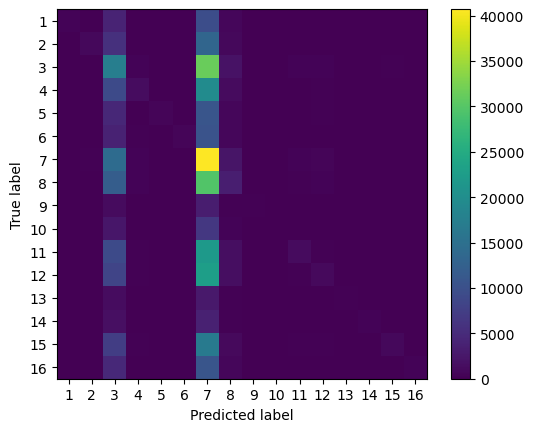

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

model = grid_search.best_estimator_

predictions = rfc.predict(x_test)
print(classification_report(y_test,predictions))
ConfusionMatrixDisplay.from_predictions(y_test,predictions,
                                        include_values=False)
plt.show()

In [ ]:
import joblib as jb

jb.dump(model, "model.lzma")